# PROJECT LUNG DISEASES

## REQUIREMENT

In [9]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Bidirectional, LSTM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

## DATA PREP

In [2]:
# flow_from_directory
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

### Datagenerator

In [3]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,            
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 8
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [4]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in resnet_model.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


### Project Model

In [11]:
#Membuat model
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(TimeDistributed(Flatten()))
model_resnet.add(Bidirectional(LSTM(128, return_sequences=True)))
model_resnet.add(Bidirectional(LSTM(16, return_sequences=True)))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dense(16, activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_resnet.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 14336)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 7, 256)            14812160  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 7, 32)             34944     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 32)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 7, 128)            4224      
_________________________________________________________________
dense_4 (Dense)              (None, 7, 16)            

In [12]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True       
                
callback = CustomCallback()
# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 130s 306ms/step - loss: 1.6115 - acc: 0.1959 - val_loss: 1.6068 - val_acc: 0.2159
Epoch 2/30
380/380 [==============================] - 85s 224ms/step - loss: 1.6074 - acc: 0.2132 - val_loss: 1.5973 - val_acc: 0.2251
Epoch 3/30
380/380 [==============================] - 86s 226ms/step - loss: 1.6009 - acc: 0.2349 - val_loss: 1.5857 - val_acc: 0.3330
Epoch 4/30
380/380 [==============================] - 85s 224ms/step - loss: 1.5885 - acc: 0.2597 - val_loss: 1.5660 - val_acc: 0.3523
Epoch 5/30
380/380 [==============================] - 85s 223ms/step - loss: 1.5784 - acc: 0.2832 - val_loss: 1.5624 - val_acc: 0.3513
Epoch 6/30
380/380 [==============================] - 85s 223ms/step - loss: 1.5670 - acc: 0.2987 - val_loss: 1.5420 - val_acc: 0.3483
Epoch 7/30
380/380 [==============================] - 88s 231ms/step - loss: 1.5514 - acc: 0.3191 - val_loss: 1.5192 - val_acc: 0.3534
Epoch 8/30
380/380 [==============================] - 

model_resnet.save("resnet_model.h5")
with open('history_resnet.txt', mode='w') as file:
    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
    file.close()

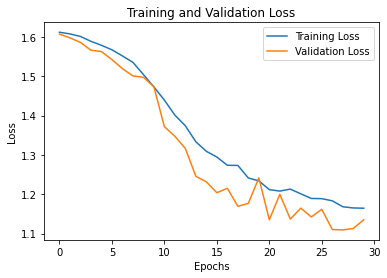

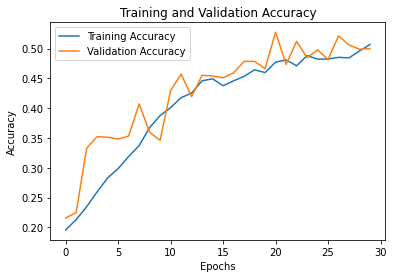

In [13]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 5s 41ms/step - loss: 1.1354 - acc: 0.5000
Loss: 1.135372519493103
Accuracy: 0.5


In [15]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nResNet50 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 81s 208ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.20284   0.17541   0.18813      1220
            covid19    0.20393   0.34272   0.25570      1243
             normal    0.19714   0.11174   0.14264      1235
       tuberculosis    0.21721   0.22222   0.21969      1170
    viral_pneumonia    0.21078   0.18069   0.19458      1212

           accuracy                        0.20674      6080
          macro avg    0.20638   0.20656   0.20015      6080
       weighted avg    0.20625   0.20674   0.20006      6080



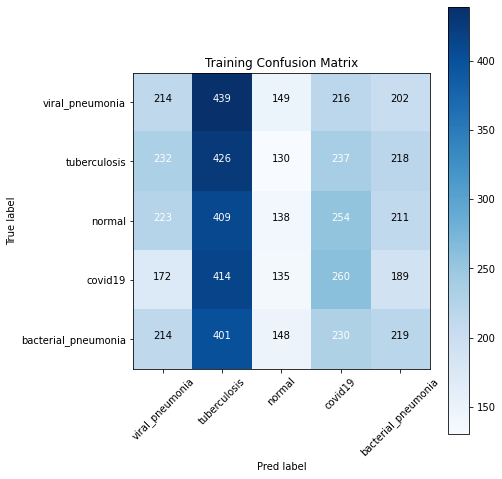

In [16]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("ResNet50 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [17]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = False

80150528/80134624 [==============================] - 0s 0us/step


### Our Model

In [19]:
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(TimeDistributed(Flatten()))
model_VGG19.add(Bidirectional(LSTM(128, return_sequences=True)))
model_VGG19.add(Bidirectional(LSTM(16, return_sequences=True)))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(128, activation='relu'))
model_VGG19.add(Dense(16, activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Flatten())
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 3584)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 7, 256)            3802112   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 7, 32)             34944     
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 32)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 7, 128)            4224      
_________________________________________________________________
dense_10 (Dense)             (None, 7, 16)            

In [20]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True              
callback = CustomCallback()
# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 93s 228ms/step - loss: 1.5876 - acc: 0.2470 - val_loss: 1.5424 - val_acc: 0.2617
Epoch 2/30
380/380 [==============================] - 84s 221ms/step - loss: 1.4974 - acc: 0.3451 - val_loss: 1.4192 - val_acc: 0.3442
Epoch 3/30
380/380 [==============================] - 85s 222ms/step - loss: 1.3824 - acc: 0.4262 - val_loss: 1.2838 - val_acc: 0.5193
Epoch 4/30
380/380 [==============================] - 83s 219ms/step - loss: 1.2471 - acc: 0.5109 - val_loss: 1.1393 - val_acc: 0.5713
Epoch 5/30
380/380 [==============================] - 85s 224ms/step - loss: 1.1383 - acc: 0.5587 - val_loss: 1.0261 - val_acc: 0.6273
Epoch 6/30
380/380 [==============================] - 85s 223ms/step - loss: 1.0572 - acc: 0.5849 - val_loss: 0.9356 - val_acc: 0.6507
Epoch 7/30
380/380 [==============================] - 84s 221ms/step - loss: 0.9774 - acc: 0.6202 - val_loss: 0.8819 - val_acc: 0.6823
Epoch 8/30
380/380 [==============================] - 8

In [ ]:
model_VGG19.save("VGG19_model_skenario1.h5")
with open('history_VGG19.txt', mode='w') as file:
    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
    file.close()

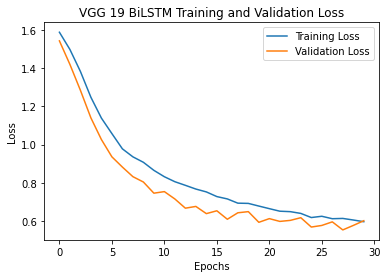

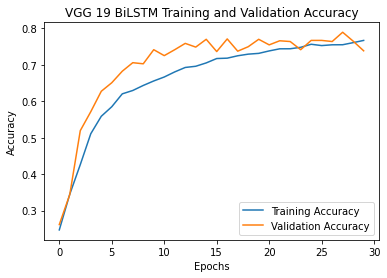

In [22]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('VGG 19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG 19 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 5s 39ms/step - loss: 0.6012 - acc: 0.7383
Loss: 0.6012320518493652
Accuracy: 0.7382891774177551


In [24]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nVGG 19 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 80s 206ms/step

VGG 19 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19961   0.25492   0.22390      1220
            covid19    0.20261   0.19952   0.20105      1243
             normal    0.21250   0.20648   0.20945      1235
       tuberculosis    0.17333   0.17778   0.17553      1170
    viral_pneumonia    0.21269   0.15759   0.18104      1212

           accuracy                        0.19951      6080
          macro avg    0.20015   0.19926   0.19819      6080
       weighted avg    0.20040   0.19951   0.19844      6080



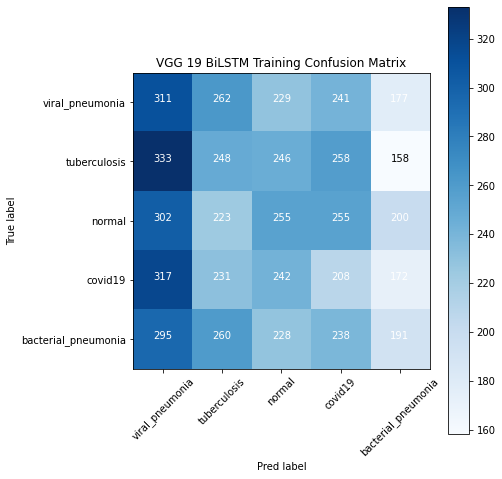

In [26]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("VGG 19 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [27]:
InceptionV3_model = InceptionV3(weights='imagenet', 
                                include_top=False, input_shape=(224, 224, 3))
# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [29]:
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(TimeDistributed(Flatten()))
model_InceptionV3.add(Bidirectional(LSTM(128, return_sequences=True)))
model_InceptionV3.add(Bidirectional(LSTM(16, return_sequences=True)))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(128, activation='relu'))
model_InceptionV3.add(Dense(16, activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))
print(model_InceptionV3.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
time_distributed_5 (TimeDist (None, 5, 10240)          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 5, 256)            10617856  
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 5, 32)             34944     
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 5, 128)            4224      
_________________________________________________________________
dense_16 (Dense)             (None, 5, 16)            

In [30]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True              
callback = CustomCallback()
# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 95s 226ms/step - loss: 1.4351 - acc: 0.4296 - val_loss: 1.2384 - val_acc: 0.6151
Epoch 2/30
380/380 [==============================] - 83s 218ms/step - loss: 1.1875 - acc: 0.5724 - val_loss: 1.0637 - val_acc: 0.6354
Epoch 3/30
380/380 [==============================] - 84s 221ms/step - loss: 1.0465 - acc: 0.6253 - val_loss: 0.9549 - val_acc: 0.6660
Epoch 4/30
380/380 [==============================] - 84s 221ms/step - loss: 0.9491 - acc: 0.6572 - val_loss: 0.8823 - val_acc: 0.6833
Epoch 5/30
380/380 [==============================] - 83s 219ms/step - loss: 0.8736 - acc: 0.6857 - val_loss: 0.8208 - val_acc: 0.7037
Epoch 6/30
380/380 [==============================] - 83s 218ms/step - loss: 0.8077 - acc: 0.7123 - val_loss: 0.7685 - val_acc: 0.7159
Epoch 7/30
380/380 [==============================] - 83s 219ms/step - loss: 0.7547 - acc: 0.7316 - val_loss: 0.7440 - val_acc: 0.7169
Epoch 8/30
380/380 [==============================] - 8

In [ ]:
model_InceptionV3.save("InceptionV3_model.h5")
with open('history_InceptionV3.txt', mode='w') as file:
    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
    file.close()

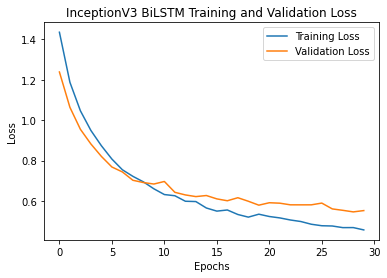

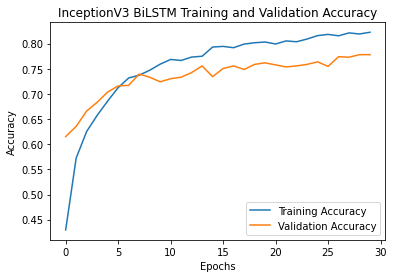

In [31]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 5s 39ms/step - loss: 0.5529 - acc: 0.7780
Loss: 0.5528694987297058
Accuracy: 0.7780040502548218


In [33]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nInceptionV3 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 80s 205ms/step

InceptionV3 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19761   0.20328   0.20040      1220
            covid19    0.19512   0.18665   0.19079      1243
             normal    0.20034   0.19190   0.19603      1235
       tuberculosis    0.20209   0.21538   0.20852      1170
    viral_pneumonia    0.20398   0.20297   0.20347      1212

           accuracy                        0.19984      6080
          macro avg    0.19983   0.20004   0.19984      6080
       weighted avg    0.19979   0.19984   0.19972      6080



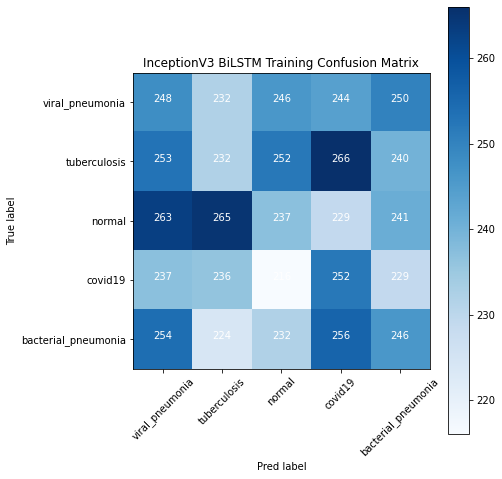

In [34]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("InceptionV3 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()